In [1]:
import json
import os
import math

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
plt.rcParams["figure.figsize"] = (12,5.5)
plt.rcParams["savefig.facecolor"] = (1,1,1)

In [3]:
dataset_paths = {
    'train': 'corpora/chemprot_train.txt',
    'dev': 'corpora/chemprot_dev.txt',
    'sample': 'corpora/chemprot_sample.txt',
    'art_train': 'corpora/artificial_train.txt',
    'art_dev': 'corpora/artificial_dev.txt', 
    'art_cp_train': 'corpora/artificial_cp_train.txt',
    'art_cp_dev': 'corpora/artificial_cp_dev.txt', 
    'art_pp_train': 'corpora/artificial_pp_train.txt',
    'art_pp_dev': 'corpora/artificial_pp_dev.txt',
    'mix_10': 'corpora/mixed_train_10.txt',
    'mix_25': 'corpora/mixed_train_25.txt'
}

In [14]:
train_path = dataset_paths['train']
dev_path = dataset_paths['dev']

model_name = 'oversampled/20'

input_path = f'models/{model_name}/metrics.txt'
output_path =  f'models/{model_name}/plots'


In [15]:
train_path, dev_path, input_path, output_path

('corpora/chemprot_train.txt',
 'corpora/chemprot_dev.txt',
 'models/oversampled/20/metrics.txt',
 'models/oversampled/20/plots')

In [16]:
if not os.path.exists(output_path):
        os.makedirs(output_path)

## Setup
Load config, data etc.

Possible improvement: Instead of saving variables, create a dictionary and kwarg dump in functions to avoid "global-style" variables

In [17]:
# with open("config.json", "r") as f:
#         config = json.loads(f.read())

In [18]:
# train_path = config["plot"]["train_path"]
# dev_path = config["plot"]["dev_path"]
# input_path = config["plot"]["metrics_path"]
# output_path = config["plot"]["output_path"]
# if not os.path.exists(output_path):
#         os.makedirs(output_path)
# train_path, dev_path, input_path, output_path

In [19]:
def read_data(filename):
  print("File: ", filename)
  with open(filename) as json_file:
    data = json.loads(json_file.read())
  
    return data


In [20]:
data = read_data(input_path)
train_key = train_path.split("/")[-1]
dev_key = dev_path.split("/")[-1]

indices = range(1, len(data['average training loss']) + 1) 

train_data, dev_data, indices, output_dir=data[train_key], data[dev_key], indices, output_path
x = list(indices)

File:  models/oversampled/20/metrics.txt


## Plotting functions
Plotting functions for loss/accuracy, single metric, scores with multiple averages & confusion matrices

In [21]:
def plot_loss_acc(data, indices, output_dir, train_key, save_to_file = True):  
  x = list(indices)
  plt.xticks(indices)

  plt.plot(x, data['average training loss'],     color="blue")
  plt.plot(x, data['average validation loss'],   color="red")
  plt.plot(x, data[train_key]['accuracy'],     color="green") # accuracies returned by the eval.py script
  plt.plot(x, data['average validation accuracy'], color="orange")

  plt.legend(['avg. training loss', 'avg. validation loss', 
              'avg. training accuracy', 'avg. validation accuracy'], 
              loc="upper center", bbox_to_anchor=(0.5, 1.23),
              fancybox=True, ncol=2)

  plt.xlabel('epoch')
  plt.tight_layout()
  
  if save_to_file: plt.savefig(output_dir + '/training_validation.png')
  plt.show()

In [22]:
def plot_metric(metric, save_to_file = True):
    plt.xticks(indices)

    plt.plot(x, train_data[metric], color="blue")
    plt.plot(x, dev_data[metric], color="red")

    plt.legend(["train", "dev"], loc="upper center", bbox_to_anchor=(0.5, 1.15),
        fancybox=True, ncol=2)

    plt.xlabel('epoch')
    plt.ylabel(metric)

    if save_to_file: plt.savefig(output_dir + '/{}.png'.format(metric))
    plt.show()
    # plt.close()

In [23]:
def plot_score_averages(metric, average_types = False, save_to_file = True):
    if not average_types: average_types = train_data[metric].keys()
    markers = {'macro' : '^', 'micro' : 'v', 'weighted' : 'x'}
    legend_list = []
    
    plt.figure()
    plt.xticks(indices)
    
    for avg_type in average_types:  
        plt.plot(x, train_data[metric][avg_type], marker=markers[avg_type])
        legend_list += [f"train {avg_type}"]
        plt.plot(x, dev_data[metric][avg_type], marker=markers[avg_type])
        legend_list += [f"dev {avg_type}"]
    
    plt.legend(legend_list, loc="upper center", bbox_to_anchor=(0.5, 1.18),
        fancybox=True, ncol=len(average_types))
    plt.xlabel('epoch')
    plt.ylabel(metric)
    
    if save_to_file: plt.savefig(output_dir + '/{}.png'.format(metric), transparent=False)
    plt.show()
    

In [24]:
def plot_confusion_matrices(data, data_name, save_to_file = True):
    class_list = ["INTERACTOR", "NOT", "PART-OF", "REGULATOR-NEGATIVE", "REGULATOR-POSITIVE"]

    row = math.ceil(math.sqrt(len(x)))
    col = math.floor(math.sqrt(len(x)))
    if row*col<len(x): col+=1

    fig, axs = plt.subplots(row, col, figsize=(5*row,7*col), sharey=True, sharex=True)
    fig.suptitle(f"{data_name} confusion matrices")

    for i in range(len(x)):
        
        cm_df = pd.DataFrame(data["confusion matrices"][i],
                    index = class_list, 
                    columns = class_list)

        g = sns.heatmap(cm_df, annot=True, cmap='Blues', ax=axs.flat[i], cbar=False, fmt='d')
        g.set_title('Epoch: ' + str(i+1))
        g.set_ylabel('Actal Values')
        g.set_xlabel('Predicted Values')
        g.xaxis.set_label_position('top')
        g.yaxis.set_label_position('right')
    
    # g.yaxis.tick_right()
    if save_to_file: plt.savefig(output_dir + '/{}-confusion.png'.format(data_name))
    plt.show()
    # plt.close()
    

## Plots

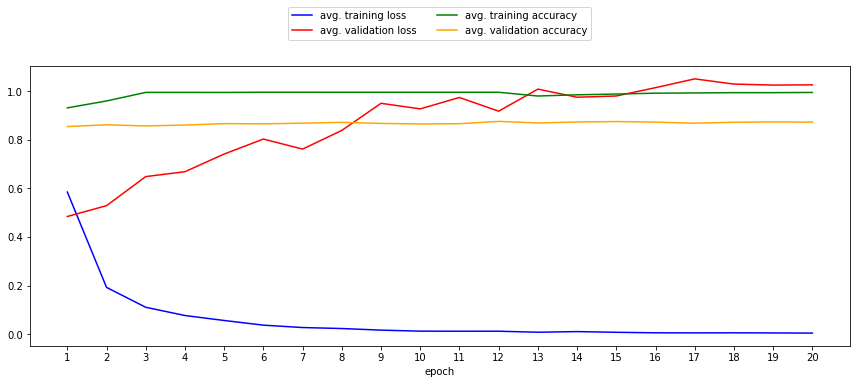

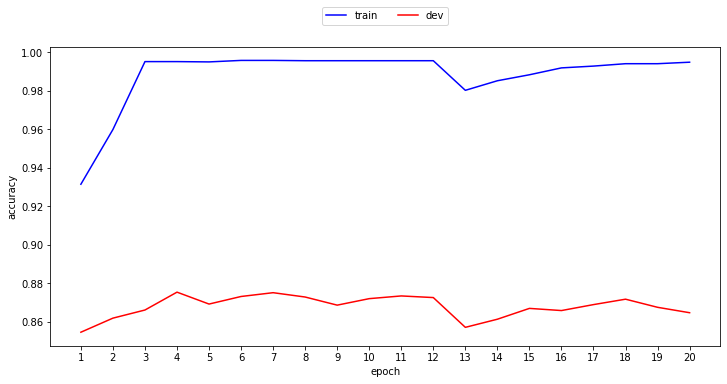

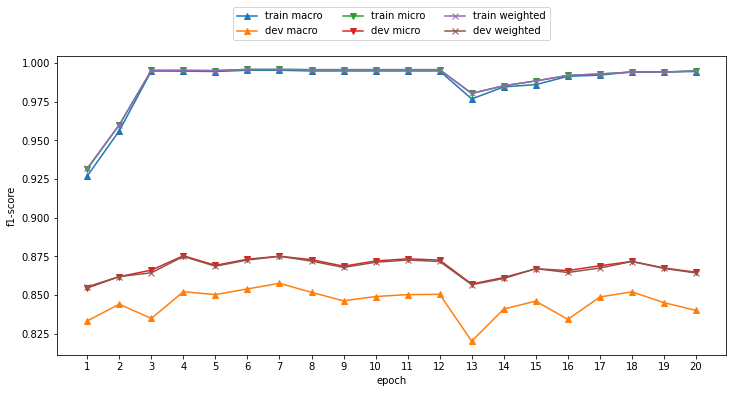

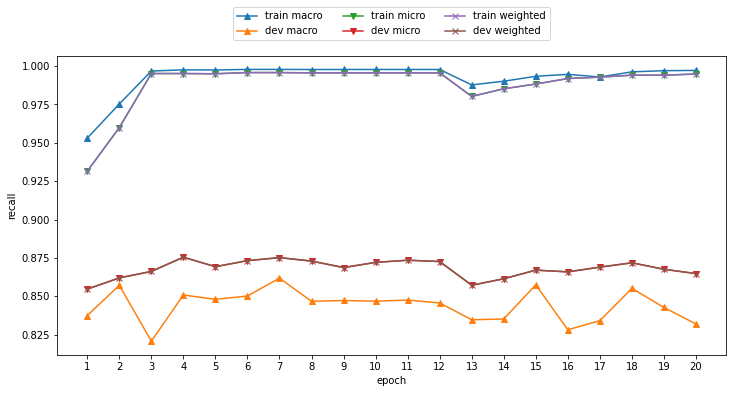

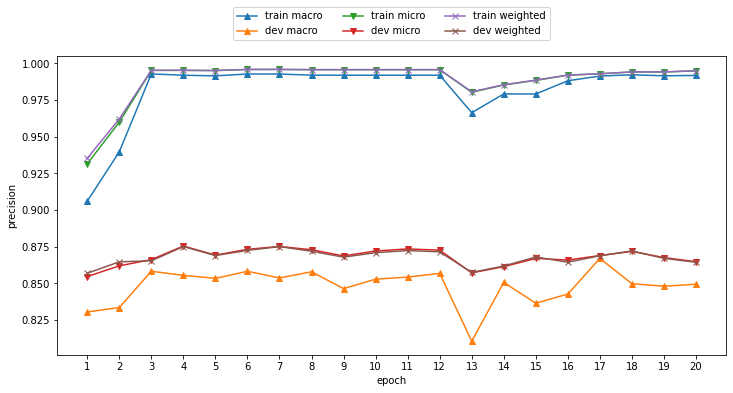

In [25]:
plot_loss_acc(data, indices, output_path, train_key)
plot_metric("accuracy")
plot_score_averages("f1-score")
plot_score_averages("recall")
plot_score_averages("precision")

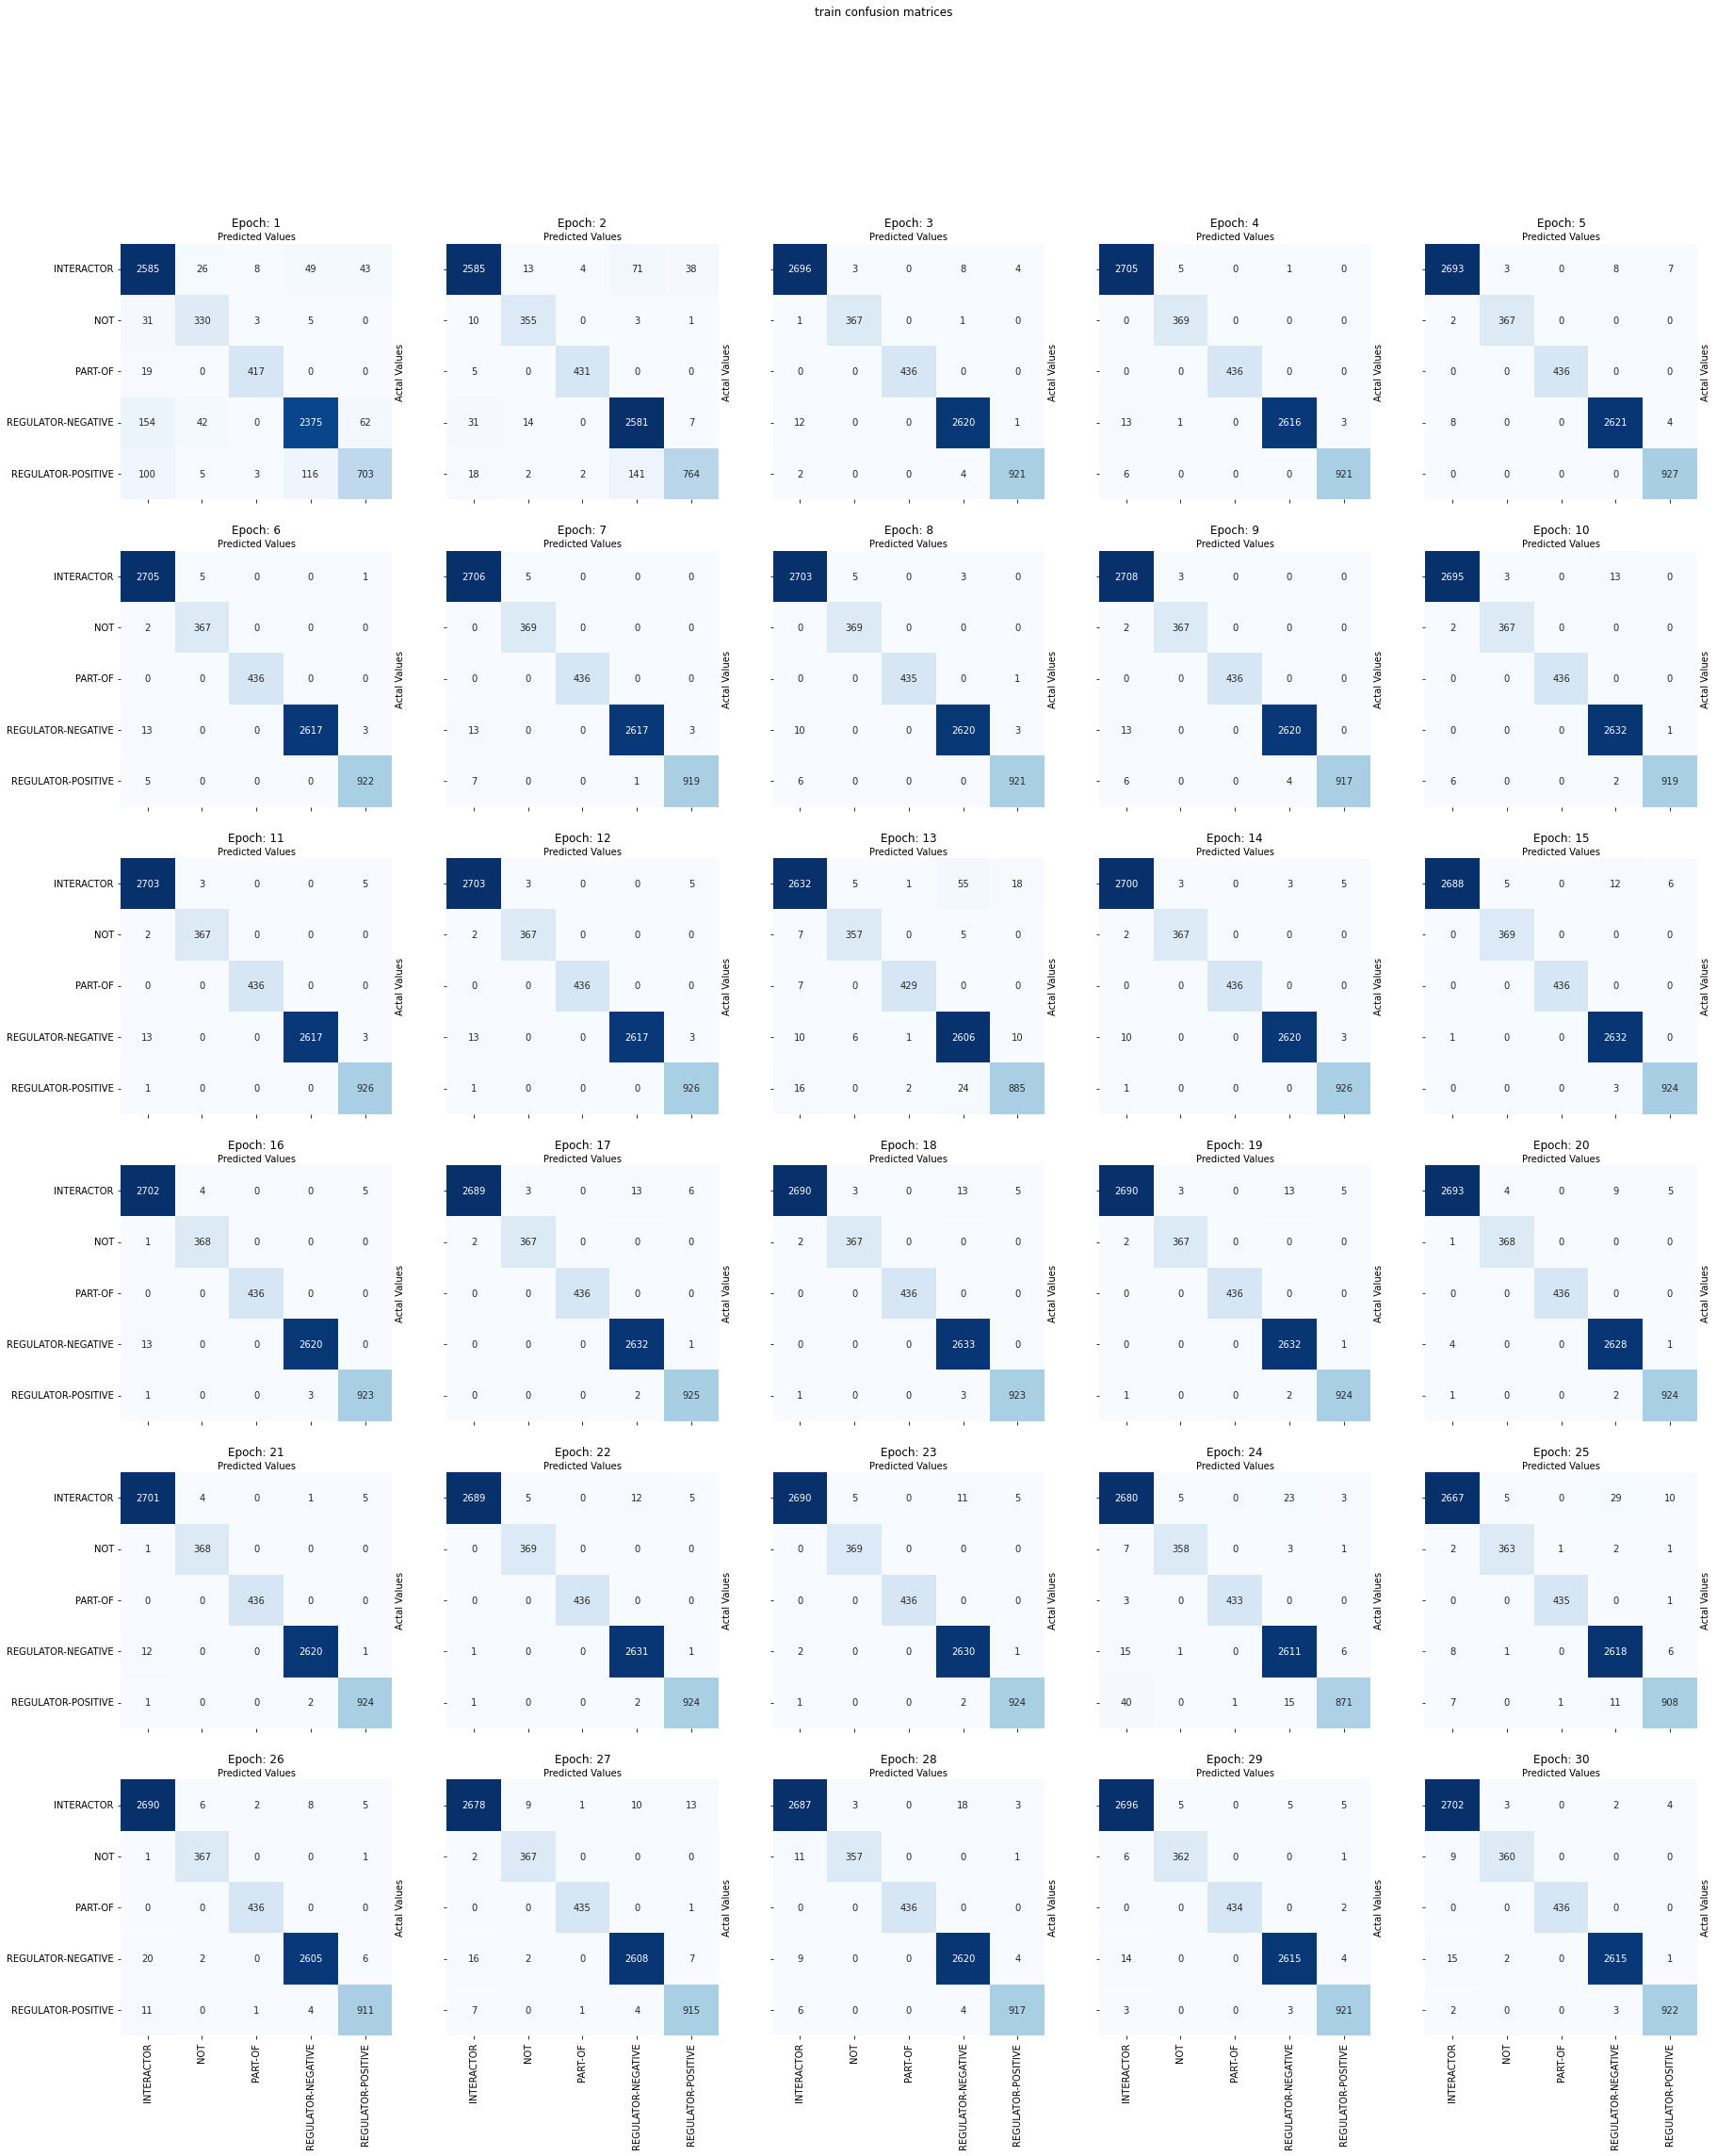

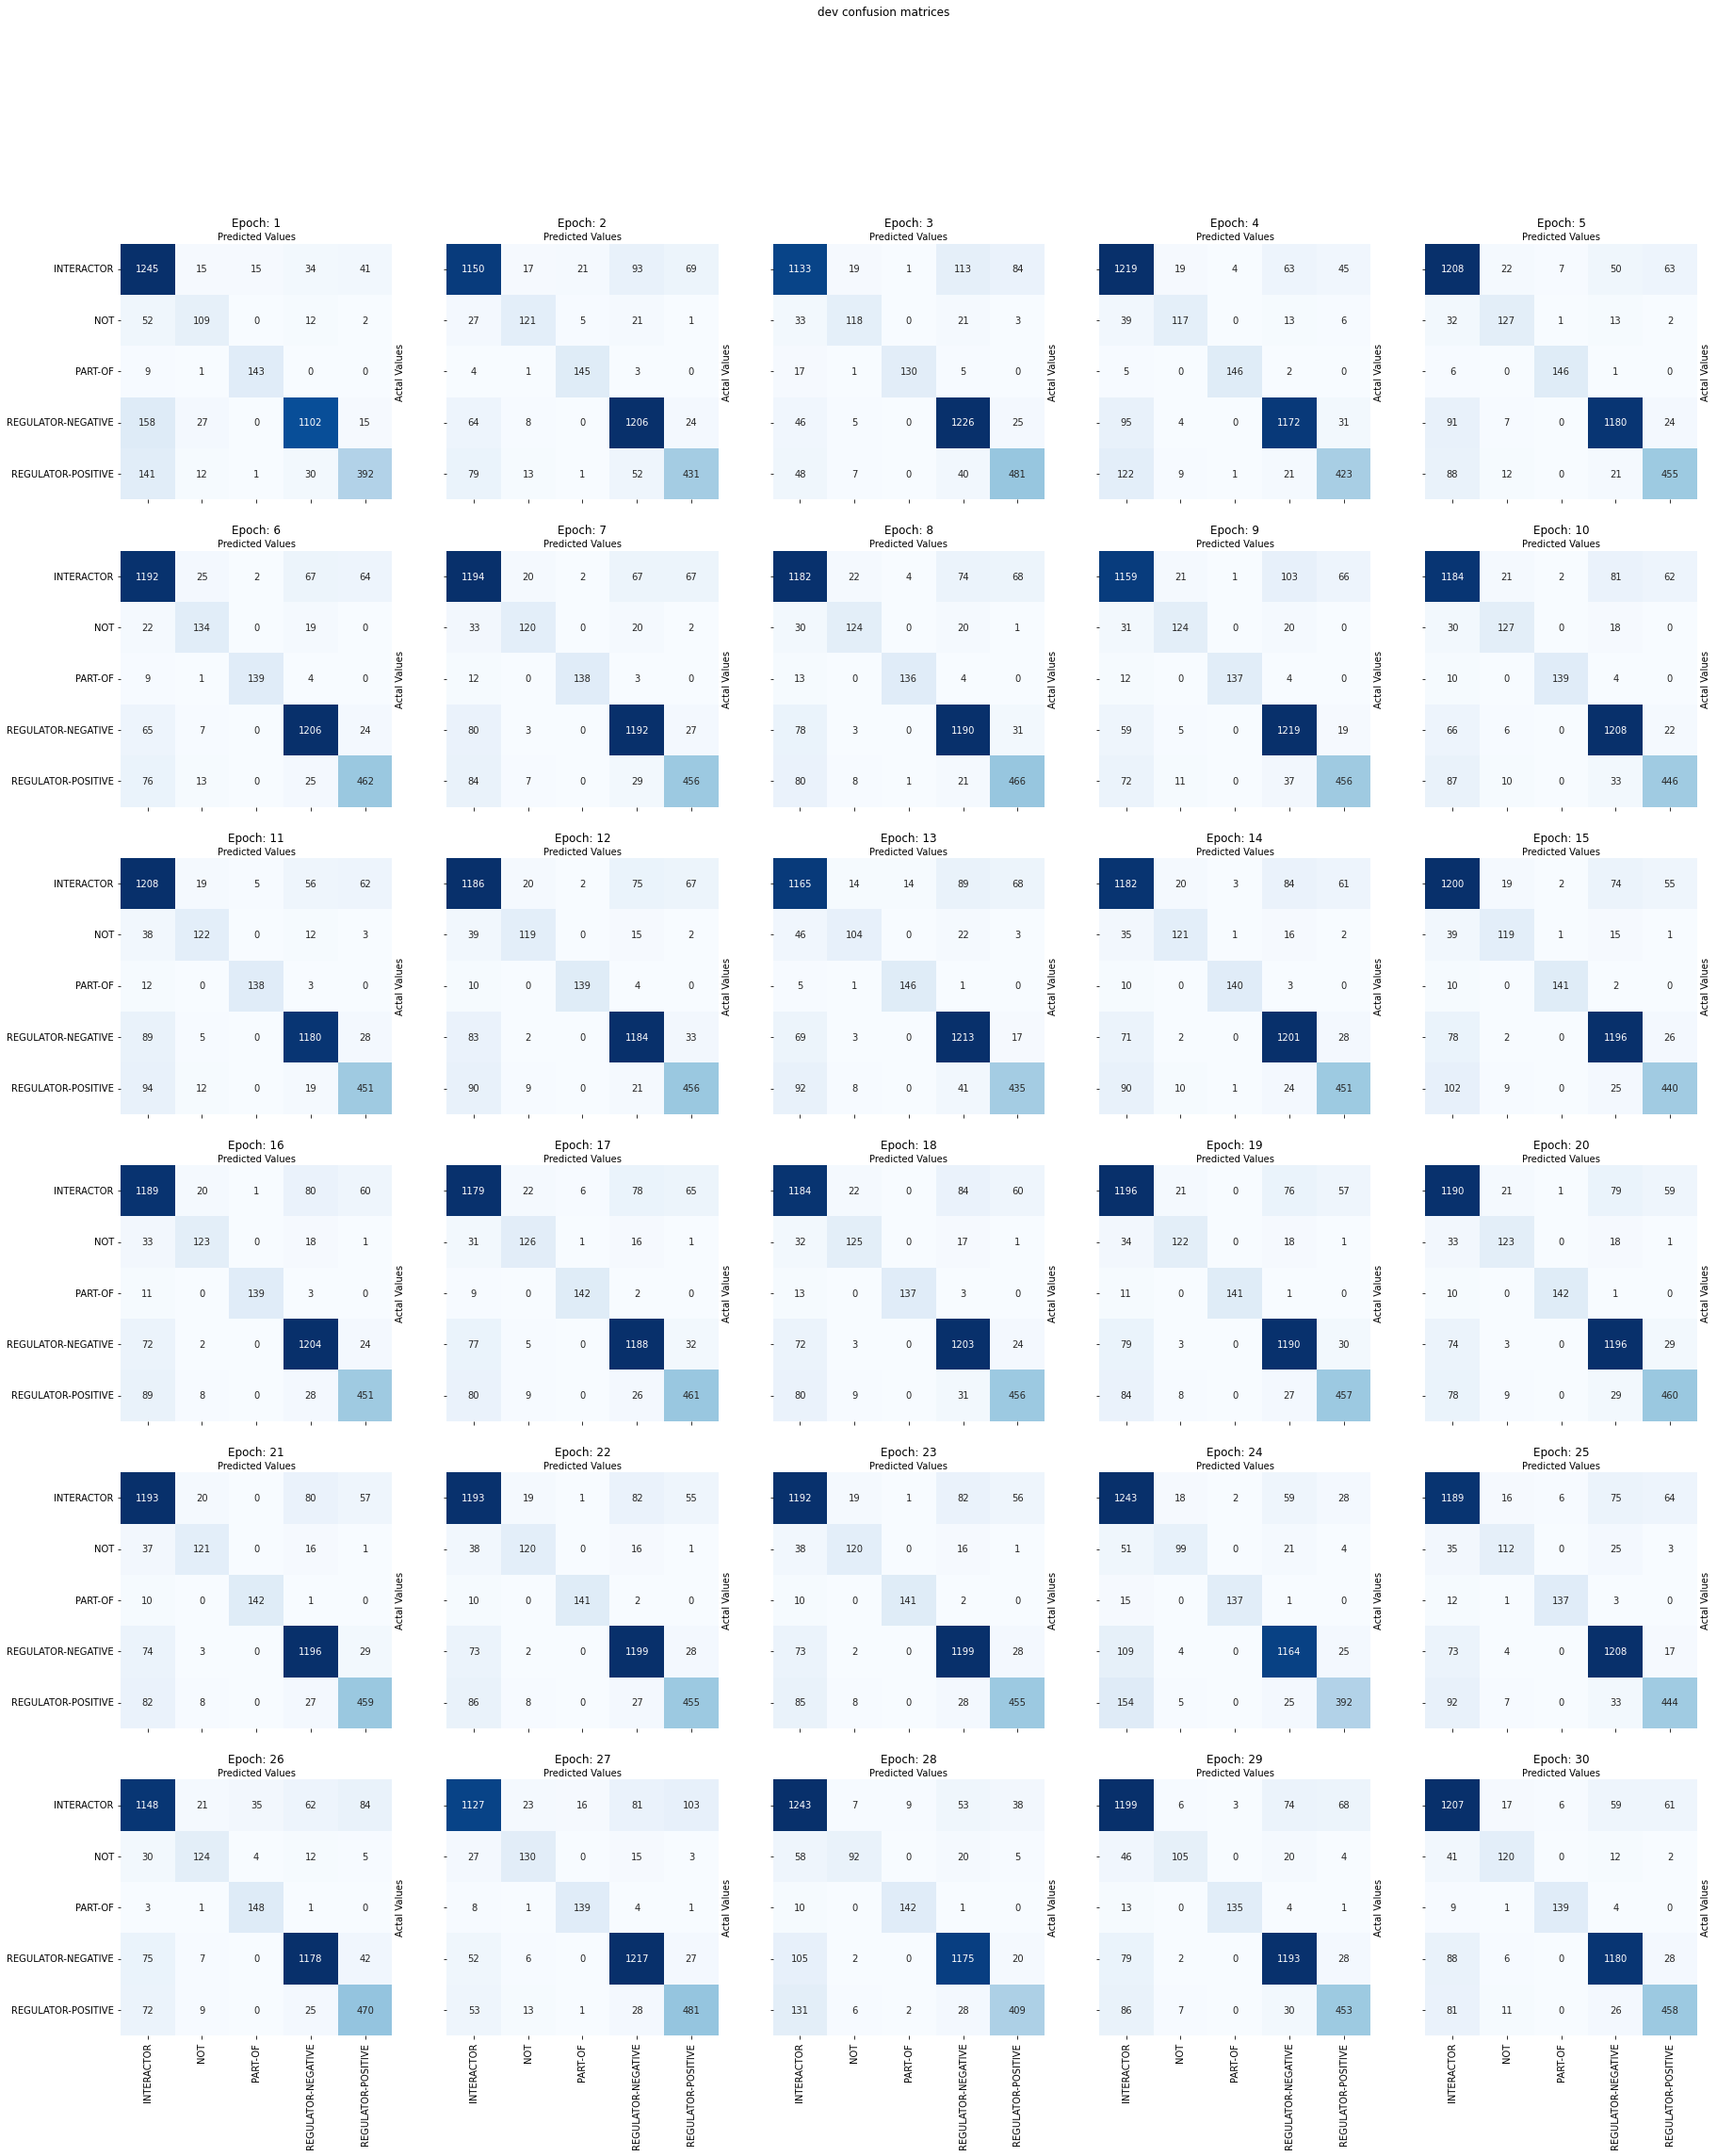

In [121]:
plot_confusion_matrices(train_data, "train")
plot_confusion_matrices(dev_data, "dev")

## Tests / Under Development

### Export to excel

In [160]:
import xlsxwriter

In [161]:
bajs = {"Source" : ["Nils"],
        "Model Name" : ["Test-model"],
        "Library" : ["Pytorch"],
        "Epochs" : [40],
        "Training corpus" : ["ChemProt train"]} 
df = pd.DataFrame.from_dict(bajs)

excel_path= 'model_summary.xlsx'

In [162]:
writer = pd.ExcelWriter(excel_path, engine = 'xlsxwriter')

In [163]:
df.to_excel(writer, sheet_name=bajs["Model Name"][0])

In [164]:
# workbook = xlsxwriter.Workbook(excel_path)
worksheet = writer.sheets[bajs["Model Name"][0]]
# worksheet.insert_image('C10',f"{output_path}/f1-score.png")
# writer.save()

# workbook.close()

In [165]:
image_paths = os.listdir(output_path)

for i in range(len(image_paths)):
    worksheet.insert_image(f'B{10 + i*30}',f'{output_path}/{image_paths[i]}')
writer.save()

In [166]:
writer.close()

In [131]:
output_path

'models/baseline/larger/plots-2'

### Investigate gradients

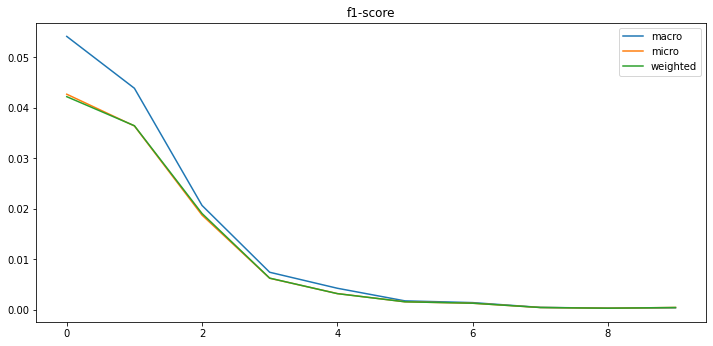

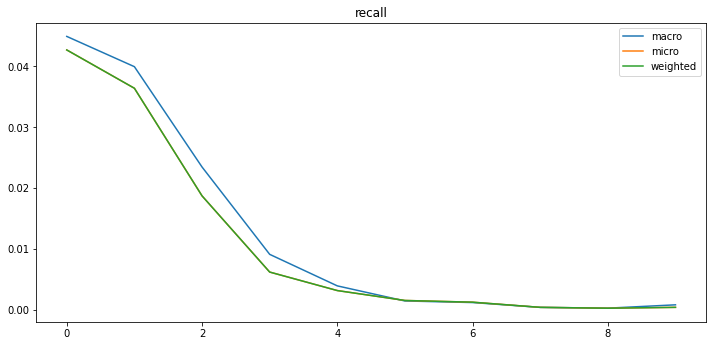

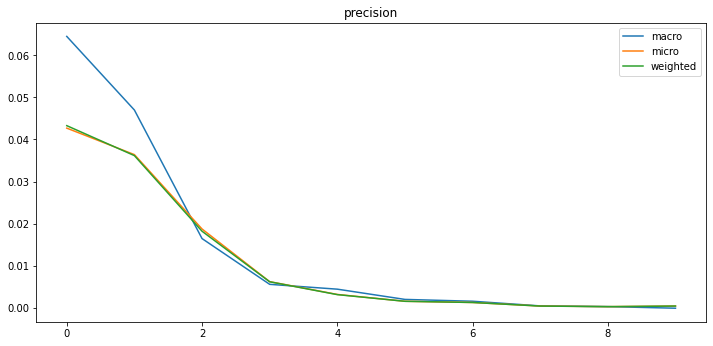

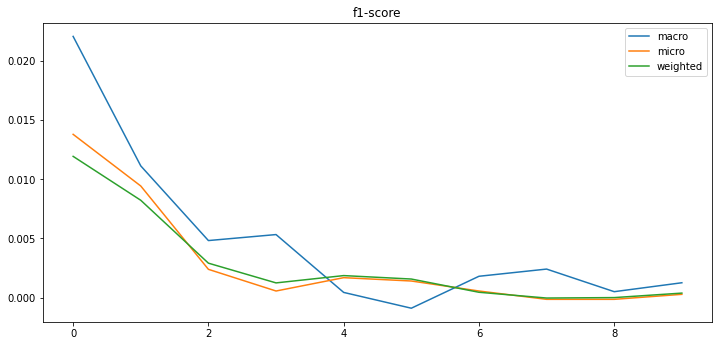

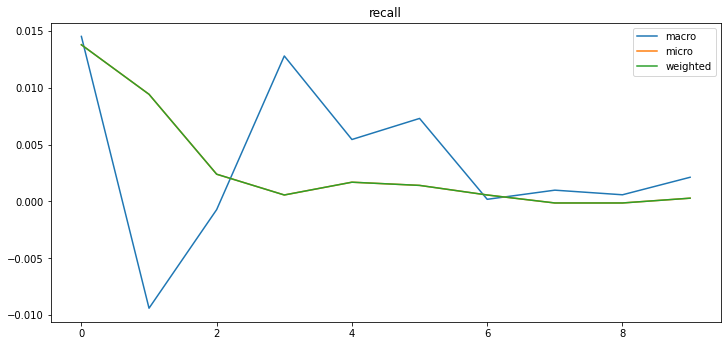

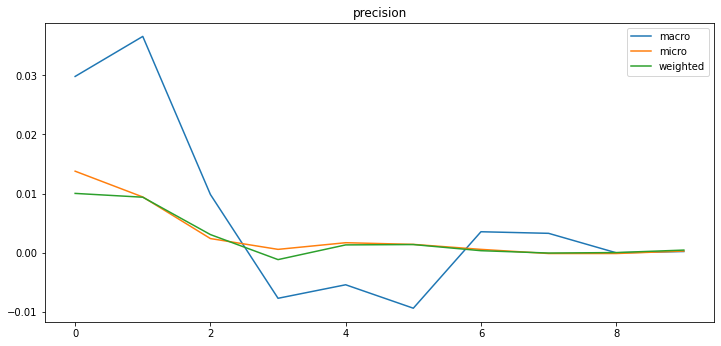

In [23]:
import numpy as np

def plot_gradients(ds_evaluation):
    scores = ['f1-score', 'recall', 'precision']
    for score in scores:
        plt.figure()
        for avg_type in ds_evaluation[score]:
            test_lista = np.array(ds_evaluation[score][avg_type])
            plt.plot(range(len(test_lista)), np.gradient(test_lista))
        plt.title(score)
        plt.legend(['macro', 'micro', 'weighted'])


plot_gradients(train_data)
plot_gradients(dev_data)


### Best model score epochs

In [17]:
def print_best_scores(ds_evaluation, ds_name):
    scores = ['f1-score', 'recall', 'precision']
    print(f'{ds_name:^32}')
    for score in scores:
        print(f"\n{score+':':<12} {'score':^10} {'epochs':^10}")
        for avg_type in ds_evaluation[score]:
            score_list = ds_evaluation[score][avg_type]
            best_value = max(score_list)
            epochs = score_list.index(best_value)
            print(f"  {avg_type+':':<10} {best_value:>10.6f} {epochs:>10}")


In [18]:
print_best_scores(train_data, 'Train set')
print_best_scores(dev_data, 'Dev set')

           Train set            

f1-score:      score      epochs  
  macro:       0.995512          9
  micro:       0.995478          9
  weighted:    0.995478          9

recall:        score      epochs  
  macro:       0.996583          9
  micro:       0.995478          9
  weighted:    0.995478          9

precision:     score      epochs  
  macro:       0.994543          8
  micro:       0.995478          9
  weighted:    0.995484          9
            Dev set             

f1-score:      score      epochs  
  macro:       0.845590          9
  micro:       0.865579          7
  weighted:    0.864939          9

recall:        score      epochs  
  macro:       0.843978          9
  micro:       0.865579          7
  weighted:    0.865579          7

precision:     score      epochs  
  macro:       0.874938          2
  micro:       0.865579          7
  weighted:    0.864752          9


In [51]:
def print_best_scores(ds_evaluation, ds_name):
    scores = ['f1-score', 'recall', 'precision']
    print(f"{'':12}  {ds_name[0]:^20} {ds_name[1]:^20}")
    print(f"{'':12} {'score':^10} {'epochs':^10} {'score':^10} {'epochs':^10}")
    for score in scores:
        print(f"{score+':':<12}")
        for avg_type in ds_evaluation[0][score]:
            score_lists = [ds_evaluation[0][score][avg_type], ds_evaluation[1][score][avg_type]]
            best_value = [max(score_lists[0]), max(score_lists[1])]
            epochs = [score_lists[0].index(best_value[0]), score_lists[1].index(best_value[1])]
            print(f"  {avg_type+':':<10} {best_value[0]:^10.6f} {epochs[0]:^10} {best_value[1]:^10.6f} {epochs[1]:^10}")
        print('')


In [53]:
print_best_scores(ds_evaluation=[train_data, dev_data], ds_name=['Train set', 'Dev set'])

                   Train set             Dev set       
               score      epochs     score      epochs  
f1-score:   
  macro:      0.995253      8       0.860963      25    
  micro:      0.995805      8       0.880765      31    
  weighted:   0.995809      10      0.879914      31    

recall:     
  macro:      0.997328      6       0.856969      21    
  micro:      0.995805      8       0.880765      31    
  weighted:   0.995805      8       0.880765      31    

precision:  
  macro:      0.995485      31      0.884660      19    
  micro:      0.995805      8       0.880765      31    
  weighted:   0.995835      10      0.879805      31    



In [58]:
print_best_scores(ds_evaluation=[train_data, dev_data], ds_name=['Train set', 'Dev set'])

                   Train set             Dev set       
               score      epochs     score      epochs  
f1-score:   
  macro:      0.995249      7       0.855119      18    
  micro:      0.995805      7       0.870641      8     
  weighted:   0.995808      7       0.870053      8     

recall:     
  macro:      0.996737      6       0.847954      6     
  micro:      0.995805      7       0.870641      8     
  weighted:   0.995805      7       0.870641      8     

precision:  
  macro:      0.994481      5       0.878008      14    
  micro:      0.995805      7       0.870641      8     
  weighted:   0.995830      7       0.869872      8     



### Slicing

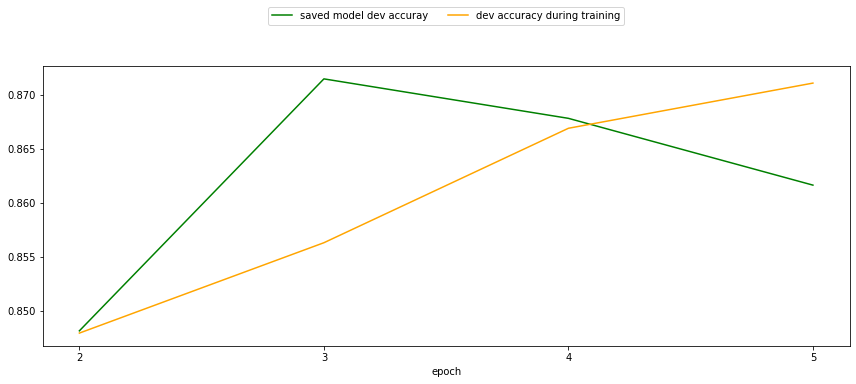

In [52]:
x = list(indices)

slce = 

plt.xticks(indices)

plt.plot(x[1:5], data[dev_key]['accuracy'][1:5],     color="green") # accuracies returned by the eval.py script
plt.plot(x[1:5], data['average validation accuracy'][1:5], color="orange")

plt.legend(["saved model dev accuray", 'dev accuracy during training'], 
            loc="upper center", bbox_to_anchor=(0.5, 1.23),
            fancybox=True, ncol=2)

plt.xlabel('epoch')
plt.tight_layout()
plt.show()